In [33]:
import sys

sys.path.append("../")

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
import itertools as it
import backtrader as bt
from pykalman import KalmanFilter

import statsmodels.api as sm

import ta
import empyrical
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [35]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOT', 'LINK', 'BCH', 'LTC', 'ALGO', 'MATIC', 'XLM', 'ETC']
symbols = [f'{s}-USDT' for s in symbols]

def get_data(start_date, end_date, use_log=True):
    data = []
    for symbol in symbols:
        try:
            file = f'{DATA_PATH}/{symbol}.csv'
            # print(file)
            df = pd.read_csv(file, 
                            parse_dates=['open_time'], 
                            index_col=['open_time'])
            df = df[(df.index > start_date) & (df.index < end_date)]
            df = df[~df.index.duplicated(keep='first')]
            df.rename(columns={'close': symbol}, inplace=True)
            if use_log:
                # the data is too long, just limit to recent period
                data.append(np.log(df[symbol]))
            else:
                data.append(df[symbol])
        except:
            pass

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how='all')
    df.dropna(inplace=True, how='any')

    return df

In [36]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(df, symbol_pairs):
    cointegrating_pairs = []
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    #     print("trace_crit_value",trace_crit_value)
    #     print("eigen_crit_value",eigen_crit_value)
    #     print("lr1",result.lr1)
    #     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)
    
    return cointegrating_pairs



In [37]:
import traceback


critical_val = 0.03


def calculate_spread(df, coint_df, nb_symbols, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


def find_stationary_portfolio(df, coint_df, nb_symbols):
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            spread = calculate_spread(df, coint_df, nb_symbols, i, hedge_ratio)
            
            p_val = adf_test(spread, verbose=False)
            if p_val < critical_val:
                half_life = cal_half_life(spread)
                pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
                # print(i, pairs_name, 'is stationary with half life', half_life)
                # print(' ')
                data.append({
                    'i': i,
                    'pairs': pairs_name,
                    'half_life': half_life
                })
            
        except:
            traceback.print_exc()
    
    stationary_df = pd.DataFrame(data)
    if len(stationary_df) > 0:
        stationary_df.sort_values(by=['half_life'], inplace=True)
    return stationary_df

def zscore(x: pd.Series, window: int):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# find_stationary_portfolio(df, coint_df, nb_symbols)


In [38]:
def calculate_coint_pairs(df, nb_symbols = 2):
    #get symbol pairs
    pairs = list(it.combinations(symbols, nb_symbols))
    cointegrating_pairs = []

    for pair in pairs:
        try:
            result = test_johansen(df, list(pair))
        except Exception:
            traceback.print_exc()
            result = []

        cointegrating_pairs.extend(result)

    coint_df = pd.DataFrame(cointegrating_pairs)
    return coint_df

In [39]:
start_date = '2021-01-01'
end_date = '2021-12-30'


df = get_data(start_date, end_date)
df.head()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOT-USDT,LINK-USDT,BCH-USDT,LTC-USDT,ALGO-USDT,MATIC-USDT,XLM-USDT,ETC-USDT
open_time,,,,,,,,,,,,,,
2021-01-01 01:00:00,10.290395,6.619179,-1.693418,3.629183,0.450757,-1.495663,2.223758,2.440693,5.858818,4.882271,-1.064211,-4.012396,-2.015453,1.748504
2021-01-01 02:00:00,10.283192,6.613586,-1.692820,3.638638,0.458753,-1.496556,2.206955,2.449452,5.871498,4.894626,-1.036201,-4.017384,-2.017782,1.754404
2021-01-01 03:00:00,10.285415,6.614565,-1.696849,3.637455,0.465870,-1.481045,2.211785,2.443998,5.862181,4.882423,-1.023598,-4.007983,-2.031490,1.748156
2021-01-01 04:00:00,10.283193,6.611234,-1.703694,3.636164,0.466058,-1.430037,2.205744,2.440084,5.853983,4.876113,-1.041004,-4.011291,-2.012680,1.755441
2021-01-01 05:00:00,10.282396,6.608823,-1.696959,3.631515,0.466686,-1.432548,2.211456,2.437815,5.853753,4.876265,-1.021374,-4.015164,-2.012082,1.751285


In [ ]:
nb_symbols = 2
coint_df = calculate_coint_pairs(df, nb_symbols)
stationary_df = find_stationary_portfolio(df, coint_df, nb_symbols)
stationary_df.head()

In [41]:
test_johansen(df, list(['LINK-USDT', 'XLM-USDT']))

[{'hedge_ratio': array([ 8.04449413, -8.43968412]),
  'sid_1': 'LINK-USDT',
  'sid_2': 'XLM-USDT'}]

In [45]:
i = 37
selected = coint_df.iloc[i].to_dict()
selected['pair'] = list(stationary_df[stationary_df.i == i].pairs.iloc[-1])
selected['half_life'] = stationary_df[stationary_df.i == i].half_life.iloc[-1]
# stationary_df.loc[i]
selected

{'hedge_ratio': array([ 8.04449413, -8.43968412]),
 'sid_1': 'LINK-USDT',
 'sid_2': 'XLM-USDT',
 'pair': ['LINK-USDT', 'XLM-USDT'],
 'half_life': 106}

In [46]:
spread = calculate_spread(df, coint_df, nb_symbols, i, selected['hedge_ratio'])
spread.dropna(inplace=True)
# spread

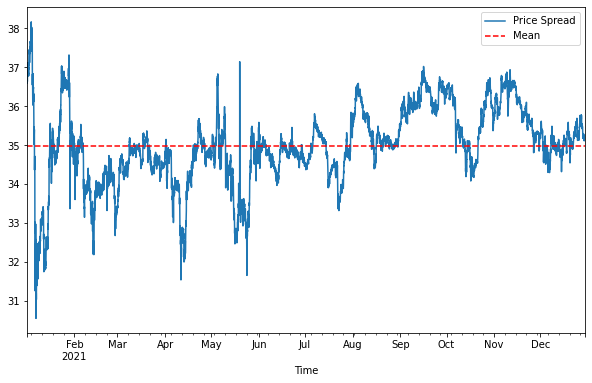

In [47]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])
plt.show()

In [48]:
def hedge_ratio(Y, X):
    # Look into using Kalman Filter to calculate the hedge ratio
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model.params[1]

hedge_r = hedge_ratio(df[selected['sid_1']], df[selected['sid_2']])

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


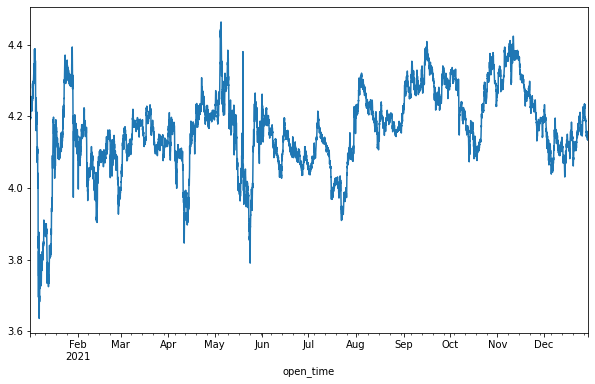

In [49]:
spread = df[selected['sid_1']] - hedge_r * df[selected['sid_2']]
spread.plot()
plt.show()